# GLM regression models using sociodemographic variables (X) and mortality (y) at different moments of the COVID-19 pandemic.

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import shapiro, pearsonr
from scipy.stats import skew, kurtosis
import numpy as np
from scipy.stats import poisson
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats
from statsmodels.nonparametric.smoothers_lowess import lowess
import pickle
import seaborn as sns

import util

## Loading data

In [27]:
df_variables = pd.read_csv('data/output/df_without_collinearity_standardized.csv', index_col=0)

In [28]:
df_y = pd.read_csv('data/outpu/df_mortality.csv', index_col=0)

In [29]:
df_municipalities = pd.read_csv('data/output/df_base_without_missing_points.csv', index_col=0)

In [30]:
df_latitude_longitude = df_municipalities[['latitude', 'longitude']].copy()

In [31]:
df_cluster_probabilities = pd.read_csv('data/df_standardized_pca_2spherical_5_probability.csv', index_col=0)
df_cluster_probabilities.columns = ['Semi-urbanized', 'Urbanized', 'Rural with high human development', 'Urbanized with informal settlements', 'Rural with low human development']

In [32]:
df_cluster_labels = pd.read_csv('data/output/df_labeled_cluster.csv', index_col=0)[['cluster_label']].copy()
custom_order = pd.CategoricalDtype(
    categories=[
        'Urbanized',
        'Urbanized with informal settlements',
        'Semi-urbanized',
        'Rural with high human development',
        'Rural with low human development'
    ],
    ordered=True
)
df_cluster_labels['cluster_label'] = df_cluster_labels['cluster_label'].astype(custom_order)
df_cluster_labels = df_cluster_labels.sort_values('cluster_label')

In [33]:
df_regions = df_municipalities[['region']].copy()
custom_order = pd.CategoricalDtype(
    categories=['Sudeste', 'Norte', 'Nordeste', 'Sul', 'Centro-Oeste'], ordered=True
)
df_regions['region'] = df_regions['region'].astype(custom_order)
df_regions = df_regions.sort_values('region')

In [34]:
df_political = pd.read_csv('data/output/df_political_without_missing_points.csv', index_col=0)[['percentual_votes_for_bolsonaro']]

In [35]:
df_vaccination_doses = pd.read_csv('data/output/df_vaccination.csv', index_col=0)[['Doses per 100 people (1/2020)', 'Doses per 100 people (2020)', 'Doses per 100 people (2020-2021)', 'Doses per 100 people (2020-2022)']]

In [36]:
df_vaccination_vaccinated_people = pd.read_csv('data/df_vaccination.csv', index_col=0)[['% people vaccinated (1/2020)', '% people vaccinated (2020)', '% people vaccinated (2020-2021)', '% people vaccinated (2020-2022)']]

In [37]:
df_vaccination_fully_vaccinated_people = pd.read_csv('data/df_vaccination.csv', index_col=0)[['% people fully vaccinated (1/2020)', '% people fully vaccinated (2020)', '% people fully vaccinated (2020-2021)', '% people fully vaccinated (2020-2022)']]

## Analyzing mortality rate distribution

Death rate (1/2020) : mean =  14.8 var =  549.56 dispersion =  37.14


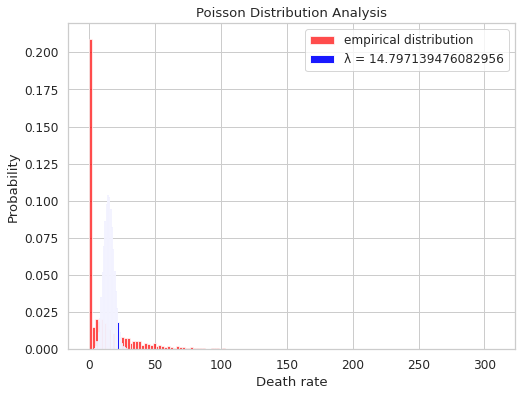

Death rate (2020) : mean =  66.16 var =  2206.48 dispersion =  33.35


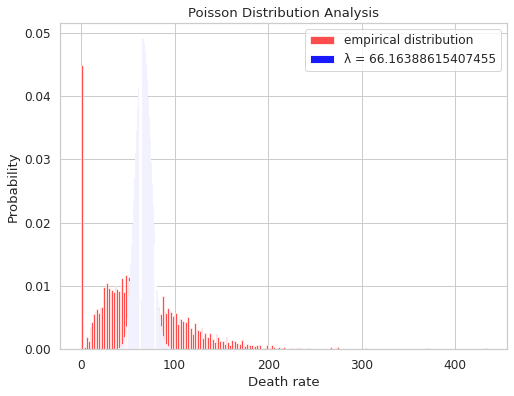

Death rate (2021) : mean =  178.35 var =  10110.95 dispersion =  56.69


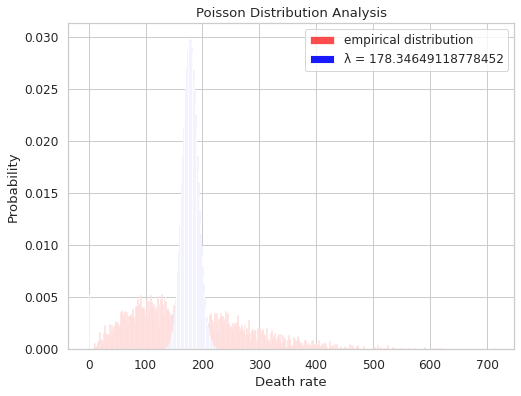

Death rate (2022) : mean =  31.61 var =  746.33 dispersion =  23.61


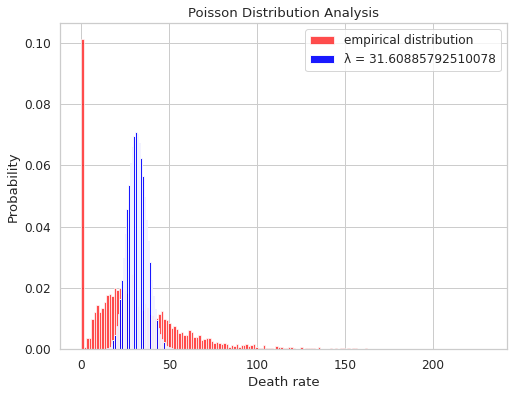

Death rate (accumulated period) : mean =  276.12 var =  16772.61 dispersion =  60.74


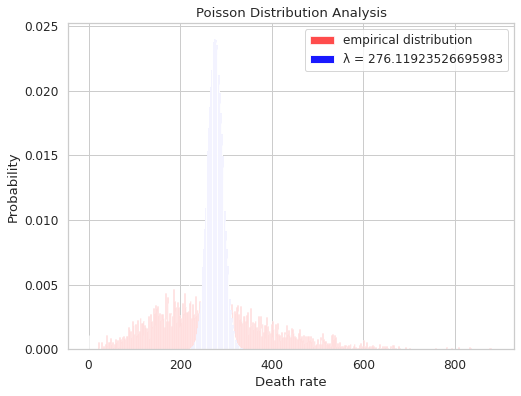

In [38]:
for column in ['Death rate (1/2020)', 'Death rate (2020)', 'Death rate (2021)', 'Death rate (2022)', 'Death rate (accumulated period)']:
    y = df_y[column].values
    y_mean = y.mean()    
    y_var = y.var()
    y_dispersion = y_var/y_mean
    print(column,':', 'mean = ', round(y_mean,2), 'var = ', round(y_var,2), 'dispersion = ', round(y_dispersion,2))
    
    y_bootstrap = np.random.choice(y, size=100000)
    
    x_values = np.arange(0, int(y_bootstrap.max()))
    pmf_values = poisson.pmf(x_values, mu=y_mean)
    
    # Plot the Poisson distribution
    plt.figure(figsize=(8, 6))
    plt.hist(y_bootstrap, bins=int(len(set(y_bootstrap.astype(int)))/1), density=True, color='red', alpha=0.7, label='empirical distribution')
    plt.bar(x_values, pmf_values, color='blue', alpha=0.9, label=f'λ = {y_mean}')
    plt.title('Poisson Distribution Analysis')
    plt.xlabel('Death rate')
    plt.ylabel('Probability')   
    plt.legend()
    plt.show()

In [39]:
df_y.columns

Index(['code_municipality_6', 'code_municipality_7', 'population', 'date',
       'region', 'deaths', 'new_deaths',
       'deaths_accumulated_first_semester_2020',
       'delta_first_death_2020-06-30', 'deaths_accumulated_2020',
       'delta_first_death_2020-12-31', 'deaths_accumulated_2021',
       'delta_first_death_2021-12-31', 'delta_first_death_2022-12-31',
       'delta_first_death_general_period',
       'death_rate_accumulated_first_semester_2020',
       'death_rate_accumulated_2020', 'death_rate_accumulated_2021',
       'Death rate (accumulated period)', 'Death rate (2022)',
       'Death rate (2021)', 'Death rate (2020)', 'Death rate (1/2020)',
       'deaths_2022', 'deaths_2021', 'death_accumulated_2020_04',
       'death_accumulated_2020_04_rate', 'death_accumulated_2020_06',
       'death_accumulated_2020_06_rate', 'death_accumulated_2020_08',
       'death_accumulated_2020_08_rate', 'death_accumulated_2020_10',
       'death_accumulated_2020_10_rate', 'death_accumula

In [40]:
for column in ['deaths_accumulated_first_semester_2020', 'deaths_accumulated_2020']:
    print('\nColumn:', column)
    print(df_y[column].describe().round(2))


Column: deaths_accumulated_first_semester_2020
count    5560.00
mean       13.98
std       179.25
min         0.00
25%         0.00
50%         1.00
75%         3.00
max      8835.00
Name: deaths_accumulated_first_semester_2020, dtype: float64

Column: deaths_accumulated_2020
count     5560.00
mean        38.21
std        336.20
min          0.00
25%          2.00
50%          6.00
75%         17.00
max      16585.00
Name: deaths_accumulated_2020, dtype: float64


In [41]:
def check_residuals_normality(residuals, residual_label):
    print('\n***Residuals: ',residual_label)
    
    statistic, p_value = shapiro(residuals)
    print("Shapiro-Wilk Test Statistic:", statistic)
    print("p-value:", p_value)    
    if p_value > 0.05:
        print("Sample looks Gaussian (fail to reject H0)")
    else:
        print("Sample does not look Gaussian (reject H0)")
    # Compute skewness
    skewness = skew(residuals)    
    # Compute kurtosis
    kurt = kurtosis(residuals)    
    # Print the results
    print("Skewness:", skewness)
    print("Kurtosis:", kurt) 
    
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title('Normal Q-Q plot')
    plt.xlabel('Theoretical Quantiles')
    plt.ylabel(residual_label)
    plt.grid(True)
    plt.show()    

In [42]:
def plot_results_basic(model, y, x):        
    plt.figure(figsize=(10, 6))
    plt.scatter(model.fittedvalues, y, color='blue', label='Predicted vs Actual', edgecolors='blue', facecolors='none')
    plt.plot(y, y, color='red', label='Perfect Fit')
    plt.xlabel('Predicted Values')
    plt.ylabel('Actual Values')
    plt.title('Predicted vs Actual Values')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    population = df_y.loc[y.index]['population']
    plt.figure(figsize=(10, 6))
    plt.scatter(model.fittedvalues/population*100000, y/population*100000, color='blue', label='Predicted vs Actual (Death rates)', edgecolors='blue', facecolors='none')
    plt.plot(y/population*100000, y/population*100000, color='red', label='Perfect Fit')
    plt.xlabel('Predicted Values')
    plt.ylabel('Actual Values')
    plt.title('Predicted vs Actual (Death rates)')
    plt.legend()
    plt.grid(True)
    plt.show()    
    

    resid_pearson = model.resid_pearson    
    standardized_pearson_residuals = resid_pearson / np.sqrt(model.fittedvalues)    
    
    plt.figure(figsize=(10, 6))
    plt.scatter(model.fittedvalues, resid_pearson, color='blue', label='Predicted vs Pearson Residuals', edgecolors='blue', facecolors='none')
    lowess_smooth = lowess(resid_pearson, model.fittedvalues, frac=0.2)
    plt.plot(lowess_smooth[:, 0], lowess_smooth[:, 1], color='red', label='LOWESS Smooth Curve')
    plt.xlabel('Predicted Values')
    plt.ylabel('resid_pearson')
    plt.title('Predicted vs Residuals')
    plt.legend()
    plt.grid(True)
    plt.show()    
    
    plt.figure(figsize=(10, 6))
    plt.scatter(model.fittedvalues, standardized_pearson_residuals, color='blue', label='Predicted vs Pearson Residuals', edgecolors='blue', facecolors='none')
    lowess_smooth = lowess(standardized_pearson_residuals, model.fittedvalues, frac=0.2)
    plt.plot(lowess_smooth[:, 0], lowess_smooth[:, 1], color='red', label='LOWESS Smooth Curve')
    plt.xlabel('Predicted Values')
    plt.ylabel('standardized_pearson_residuals')
    plt.title('Predicted vs Residuals')
    plt.legend()
    plt.grid(True)
    plt.show()    

    check_residuals_normality(resid_pearson, 'resid_pearson')
    check_residuals_normality(standardized_pearson_residuals, 'standardized_pearson_residuals')

In [43]:
def plot_results(model, y, x):        
    plt.figure(figsize=(10, 6))
    plt.scatter(model.fittedvalues, y, color='blue', label='Predicted vs Actual', edgecolors='blue', facecolors='none')
    plt.plot(y, y, color='red', label='Perfect Fit')
    plt.xlabel('Predicted Values')
    plt.ylabel('Actual Values')
    plt.title('Predicted vs Actual Values')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    population = df_y.loc[y.index]['population']
    plt.figure(figsize=(10, 6))
    plt.scatter(model.fittedvalues/population*100000, y/population*100000, color='blue', label='Predicted vs Actual (Death rates)', edgecolors='blue', facecolors='none')
    plt.plot(y/population*100000, y/population*100000, color='red', label='Perfect Fit')
    plt.xlabel('Predicted Values')
    plt.ylabel('Actual Values')
    plt.title('Predicted vs Actual (Death rates)')
    plt.legend()
    plt.grid(True)
    plt.show()    
    
    resid_response = model.resid_response
    resid_pearson = model.resid_pearson
    quantile_residuals = resid_response / np.sqrt(model.fittedvalues)
    
    standardized_pearson_residuals = resid_pearson / np.sqrt(model.fittedvalues)
    standardized_quantile_residuals = quantile_residuals / quantile_residuals.std()
    
    plt.figure(figsize=(10, 6))
    plt.scatter(model.fittedvalues, resid_pearson, color='blue', label='Predicted vs Pearson Residuals', edgecolors='blue', facecolors='none')
    lowess_smooth = lowess(resid_pearson, model.fittedvalues, frac=0.2)
    plt.plot(lowess_smooth[:, 0], lowess_smooth[:, 1], color='red', label='LOWESS Smooth Curve')
    plt.xlabel('Predicted Values')
    plt.ylabel('resid_pearson')
    plt.title('Predicted vs Residuals')
    plt.legend()
    plt.grid(True)
    plt.show()    
    
    plt.figure(figsize=(10, 6))
    plt.scatter(model.fittedvalues, standardized_pearson_residuals, color='blue', label='Predicted vs Pearson Residuals', edgecolors='blue', facecolors='none')
    lowess_smooth = lowess(standardized_pearson_residuals, model.fittedvalues, frac=0.2)
    plt.plot(lowess_smooth[:, 0], lowess_smooth[:, 1], color='red', label='LOWESS Smooth Curve')
    plt.xlabel('Predicted Values')
    plt.ylabel('standardized_pearson_residuals')
    plt.title('Predicted vs Residuals')
    plt.legend()
    plt.grid(True)
    plt.show()    
    
    plt.figure(figsize=(10, 6))
    plt.scatter(model.fittedvalues, standardized_quantile_residuals, color='blue', label='Predicted vs Pearson Residuals', edgecolors='blue', facecolors='none')
    lowess_smooth = lowess(standardized_quantile_residuals, model.fittedvalues, frac=0.2)
    plt.plot(lowess_smooth[:, 0], lowess_smooth[:, 1], color='red', label='LOWESS Smooth Curve')
    plt.xlabel('Predicted Values')
    plt.ylabel('standardized_quantile_residuals')
    plt.title('Predicted vs Residuals')
    plt.legend()
    plt.grid(True)
    plt.show()    
    
    check_residuals_normality(resid_response, 'resid_response')
    check_residuals_normality(resid_pearson, 'resid_pearson')
    check_residuals_normality(standardized_pearson_residuals, 'standardized_pearson_residuals')
    check_residuals_normality(quantile_residuals, 'quantile_residuals')
    check_residuals_normality(standardized_quantile_residuals, 'standardized_quantile_residuals')

    df_municipalities_temp = df_municipalities.loc[y.index]

    plt.figure(figsize=(10, 6))
    plt.scatter(df_municipalities_temp['longitude'], quantile_residuals, color='blue', label='Longitude vs residuals', edgecolors='blue', facecolors='none')
    lowess_smooth = lowess(quantile_residuals, df_municipalities_temp['longitude'], frac=0.2)
    plt.plot(lowess_smooth[:, 0], lowess_smooth[:, 1], color='red', label='LOWESS Smooth Curve')
    plt.xlabel('Longitude')
    plt.ylabel('Residuals')
    plt.title('Longitude vs Residuals')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.scatter(df_municipalities_temp['latitude'], quantile_residuals, color='blue', label='Latitude vs residuals', edgecolors='blue', facecolors='none')
    lowess_smooth = lowess(quantile_residuals, df_municipalities_temp['latitude'], frac=0.2)
    plt.plot(lowess_smooth[:, 0], lowess_smooth[:, 1], color='red', label='LOWESS Smooth Curve')
    plt.xlabel('Latitude')
    plt.ylabel('Residuals')
    plt.title('Latitude vs Residuals')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    for i in range(len(x.columns[1:])):
        plt.figure(figsize=(10, 6))
        plt.scatter(x[x.columns[1:][i]], quantile_residuals, color='blue', edgecolors='blue', facecolors='none')
        lowess_smooth = lowess(quantile_residuals, x[x.columns[1:][i]], frac=0.2)
        plt.plot(lowess_smooth[:, 0], lowess_smooth[:, 1], color='red', label='LOWESS Smooth Curve')
        plt.xlabel(x.columns[1:][i])
        plt.ylabel('Quantile Residuals')        
        plt.grid(True)
        plt.show()    

In [44]:
def collinearity_analysis(df_x):
    vif_data = pd.DataFrame()
    vif_data['Feature'] = df_x.columns
    vif_data['VIF'] = [variance_inflation_factor(df_x.values, i) for i in range(df_x.shape[1])]
    return vif_data

In [45]:
def plot_pearson(df):
    palette = util.get_default_colors_heatmap()
    # Assuming df_without_collinearity_standardized is your DataFrame
    attributes = df.columns[:]
    n = len(attributes)
    yticks = [f"{i + 1} - {attr}" for i, attr in enumerate(attributes)]
    xticks = list(range(1, n + 1))

    # Select the desired attributes
    df_selected_attributes = df[attributes]

    # Calculate the Pearson correlation matrix
    correlation = df_selected_attributes.corr()

    # Initialize a matrix for p-values
    pvalue = np.zeros((n, n))

    # Compute p-values
    for i in range(n):
        for j in range(n):
            if i != j:
                _, pvalue[i, j] = pearsonr(df_selected_attributes.iloc[:, i], df_selected_attributes.iloc[:, j])
            else:
                pvalue[i, j] = np.nan  # NaN for diagonal

    # Round p-values to two decimal places
    pvalue = np.round(pvalue, 2)

    # Create a mask to hide the upper triangle
    mask = np.zeros_like(correlation, dtype=bool)
    mask[np.triu_indices_from(mask, k=1)] = True

    # Set plot dimensions
    largura = 70
    altura = 50

    # Convert dimensions from centimeters to inches
    def centimeter_to_inch(cm):
        return cm / 2.54

    # Set seaborn style
    sns.set(font_scale=1.1)
    sns.set_style("ticks")

    # Plot the correlation heatmap with annotations for correlation values
    f, ax = plt.subplots(figsize=(centimeter_to_inch(largura), centimeter_to_inch(altura)))
    ax = sns.heatmap(correlation, vmin=-1, vmax=1, center=0, square=False, mask=mask, cmap=palette,
                     yticklabels=yticks, xticklabels=xticks, annot=correlation, fmt=".2f",
                     cbar_kws={"orientation": "horizontal"}, cbar=True)
    plt.xticks(rotation=0)
    plt.show()

In [46]:
def run_model(x, y, model_name, period, list_offset_extra=None, list_offset_extra_2=None):
    list_population =  df_y['population']
    list_offset_default = np.log(list_population)
    
    model_name_period = model_name + '_' + period
    print('\n===>',model_name_period)
    print(collinearity_analysis(x))
    plot_pearson(x)
    x = sm.add_constant(x)
    model = util.tunning_negative_binomial_model(x, y, list_offset_default, list_offset_extra, list_offset_extra_2)
    util.save_model(model, model_name_period)
    util.summarize_results(model)
    plot_results_basic(model, y, x)
    util.outlier_analysis(model)
    return model

In [47]:
df_regions['region'].unique()

['Sudeste', 'Norte', 'Nordeste', 'Sul', 'Centro-Oeste']
Categories (5, object): ['Sudeste' < 'Norte' < 'Nordeste' < 'Sul' < 'Centro-Oeste']

## Statistical analysis
Model 0: regions without any control.<br/>
Model 1: regions controlled by temporal factor.<br/>
Model 2: clusters without any control.<br/>
Model 3: clusters controlled by temporal factor.<br/>
Model 4: latitude and longitude without any control.<br/>
Model 5: latitude, longitude, and clusters without any control. <br/>
Model 6: cluster probabilities without any control. <br/>
Model 7: latitude, longitude, and cluster probabilities without any control. <br/>
Model 8: latitude, longitude, and cluster probabilities controlled by temporal factor. <br/>
Model 9: cluster probabilities controlled by temporal factor. <br/>
Model 10: sociodemographic variables, political preference, and vaccination coverage controlled by temporal factor. <br/>



*** Period:  2020_1
Death mean:  13.98 variance:  32131.92 dispersion:  2298.62

===> model_6_2020_1
                               Feature       VIF
0                       Semi-urbanized  1.043208
1    Rural with high human development  1.003342
2  Urbanized with informal settlements  1.005715
3     Rural with low human development  1.034764


/home/helder/anaconda3/envs/base-r/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


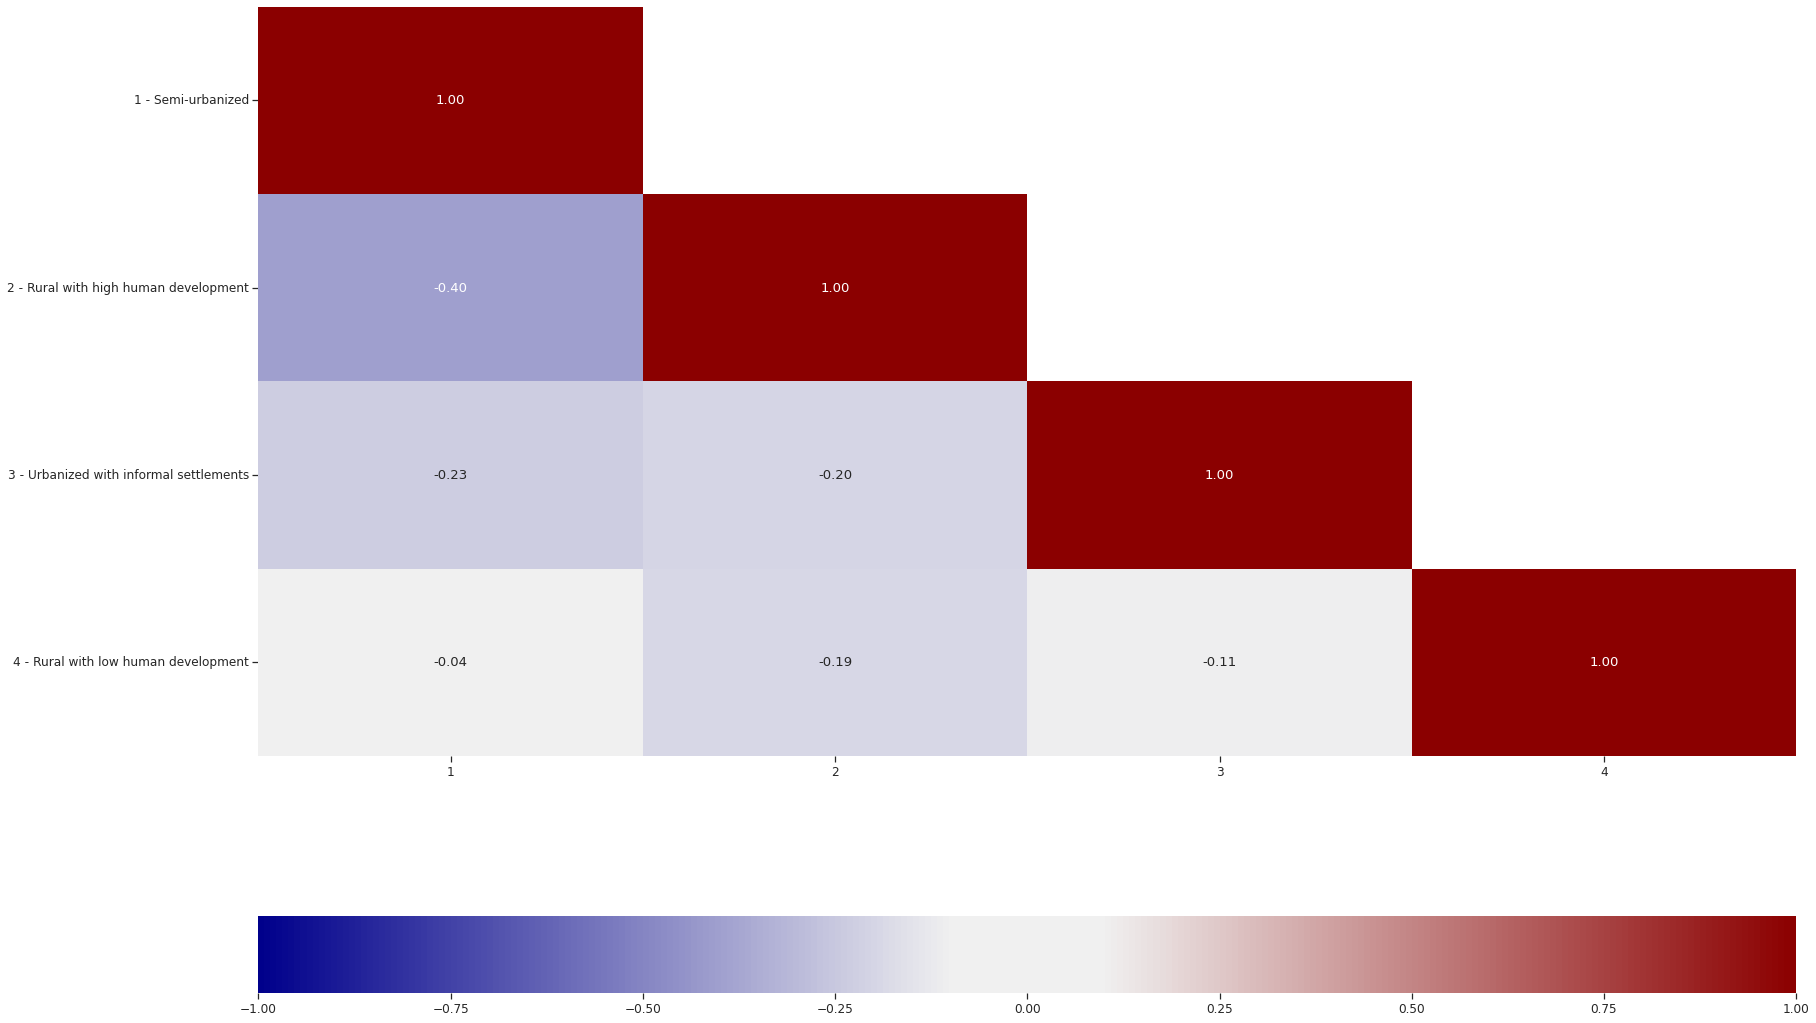

Selected alpha: 0.9400000000000001
                           Generalized Linear Model Regression Results                            
Dep. Variable:     deaths_accumulated_first_semester_2020   No. Observations:                 5560
Model:                                                GLM   Df Residuals:                     5555
Model Family:                            NegativeBinomial   Df Model:                            4
Link Function:                                        Log   Scale:                          1.0000
Method:                                              IRLS   Log-Likelihood:                -10380.
Date:                                    Mon, 30 Dec 2024   Deviance:                       5282.3
Time:                                            21:34:31   Pearson chi2:                 6.21e+03
No. Iterations:                                         9   Pseudo R-squ. (CS):             0.2485
Covariance Type:                                nonrobust                 

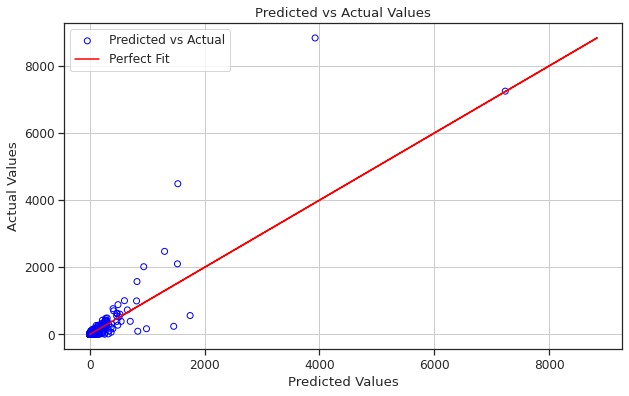

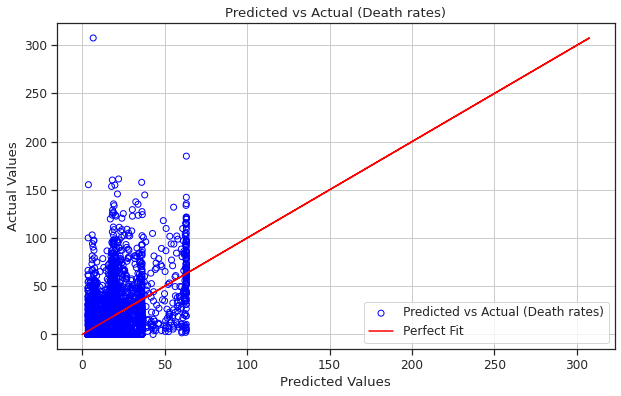

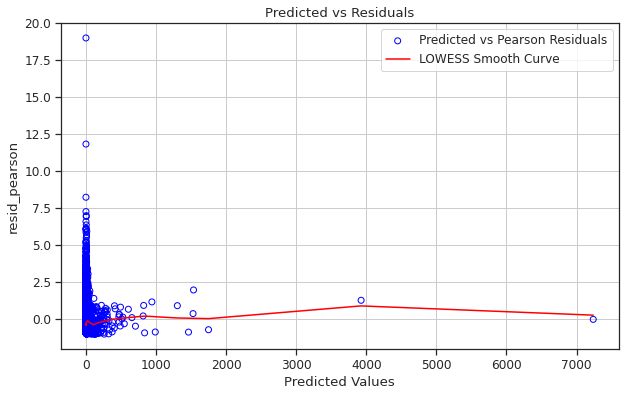

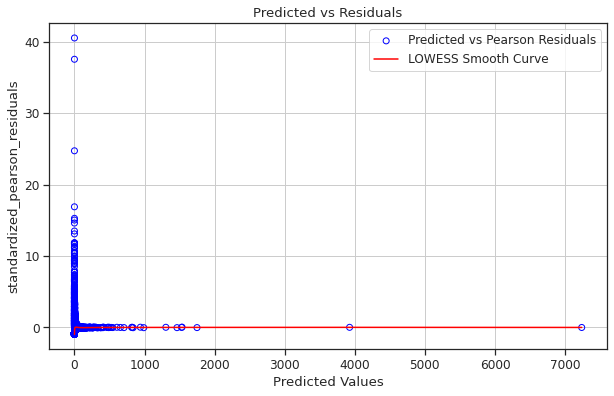


***Residuals:  resid_pearson
Shapiro-Wilk Test Statistic: 0.7162473201751709
p-value: 0.0
Sample does not look Gaussian (reject H0)
Skewness: 3.380890457117608
Kurtosis: 27.648642802191823


/home/helder/anaconda3/envs/base-r/lib/python3.9/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


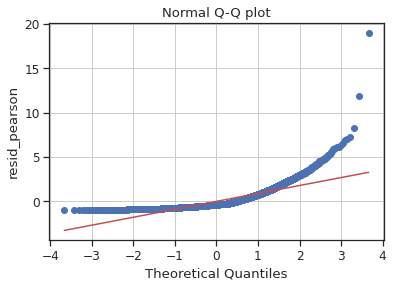


***Residuals:  standardized_pearson_residuals
Shapiro-Wilk Test Statistic: 0.468004047870636
p-value: 0.0
Sample does not look Gaussian (reject H0)
Skewness: 9.40446636533252
Kurtosis: 171.26361638037554


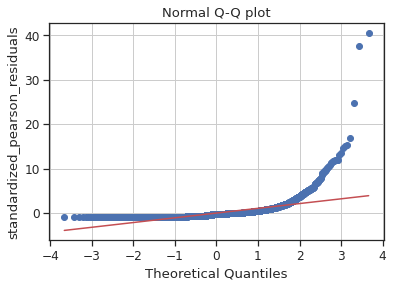

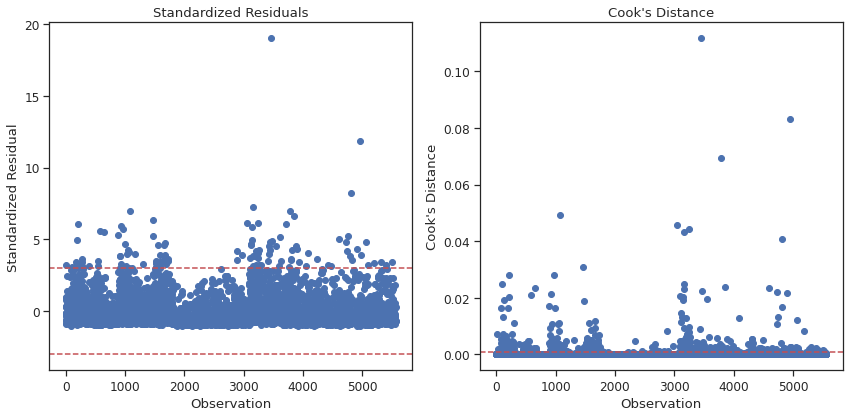

Quantity outliers (Standardized Residuals > 3): 122
Quantity influential Points (Cook's Distance > 4/n): 452

*** Period:  2020
Death mean:  38.21 variance:  113029.96 dispersion:  2958.2

===> model_6_2020
                               Feature       VIF
0                       Semi-urbanized  1.043208
1    Rural with high human development  1.003342
2  Urbanized with informal settlements  1.005715
3     Rural with low human development  1.034764


/home/helder/anaconda3/envs/base-r/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


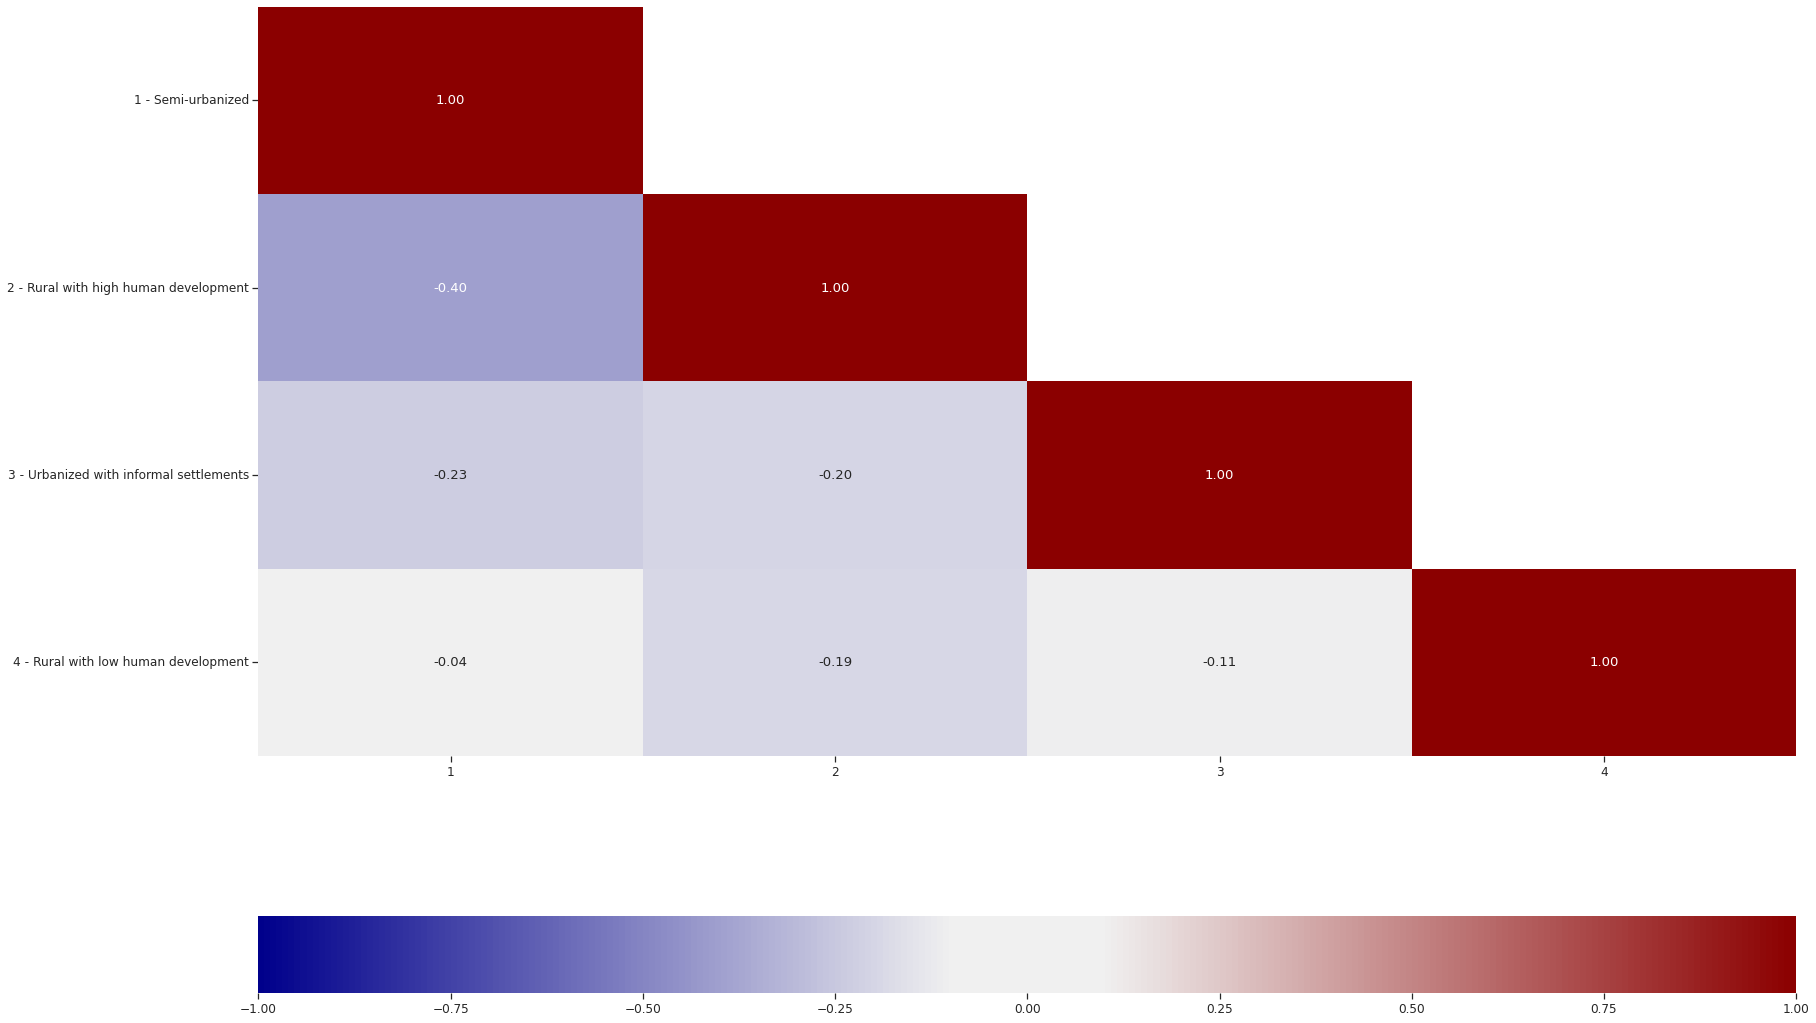

Selected alpha: 0.24000000000000002
                    Generalized Linear Model Regression Results                    
Dep. Variable:     deaths_accumulated_2020   No. Observations:                 5560
Model:                                 GLM   Df Residuals:                     5555
Model Family:             NegativeBinomial   Df Model:                            4
Link Function:                         Log   Scale:                          1.0000
Method:                               IRLS   Log-Likelihood:                -16669.
Date:                     Mon, 30 Dec 2024   Deviance:                       6250.0
Time:                             21:34:41   Pearson chi2:                 5.81e+03
No. Iterations:                          7   Pseudo R-squ. (CS):             0.1156
Covariance Type:                 nonrobust                                         
                                          coef    std err          z      P>|z|      [0.025      0.975]
--------------------

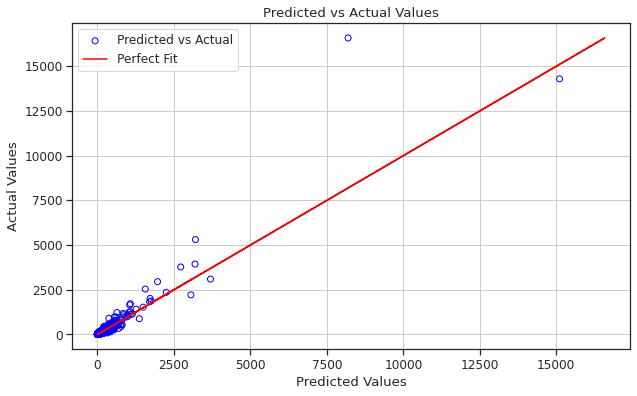

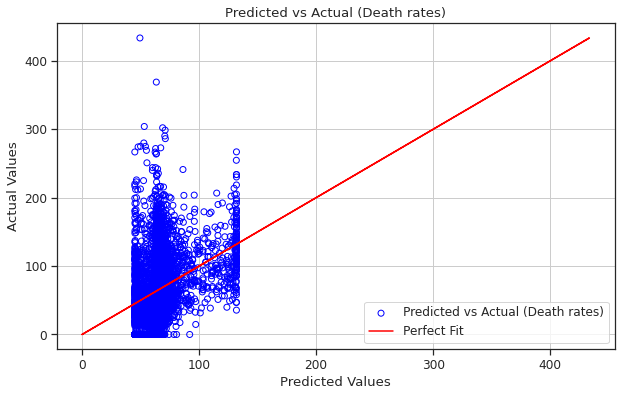

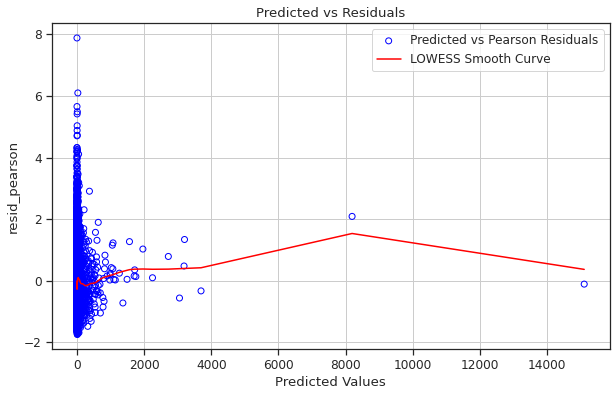

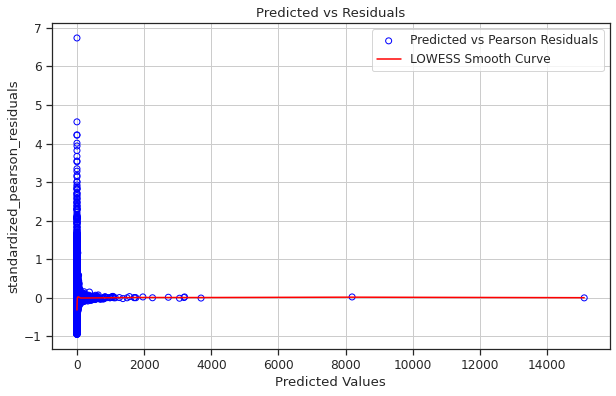


***Residuals:  resid_pearson
Shapiro-Wilk Test Statistic: 0.9334490299224854
p-value: 2.2420775429197073e-44
Sample does not look Gaussian (reject H0)
Skewness: 1.1328884778984343
Kurtosis: 2.1850461108105517


/home/helder/anaconda3/envs/base-r/lib/python3.9/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


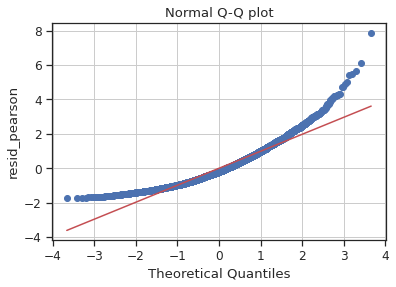


***Residuals:  standardized_pearson_residuals
Shapiro-Wilk Test Statistic: 0.8486220240592957
p-value: 0.0
Sample does not look Gaussian (reject H0)
Skewness: 2.339177895381236
Kurtosis: 14.110178228823038


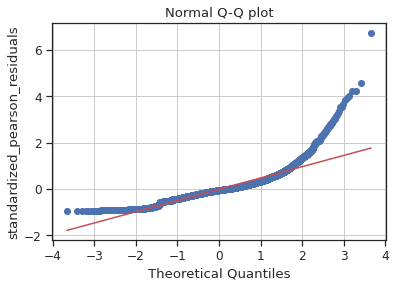

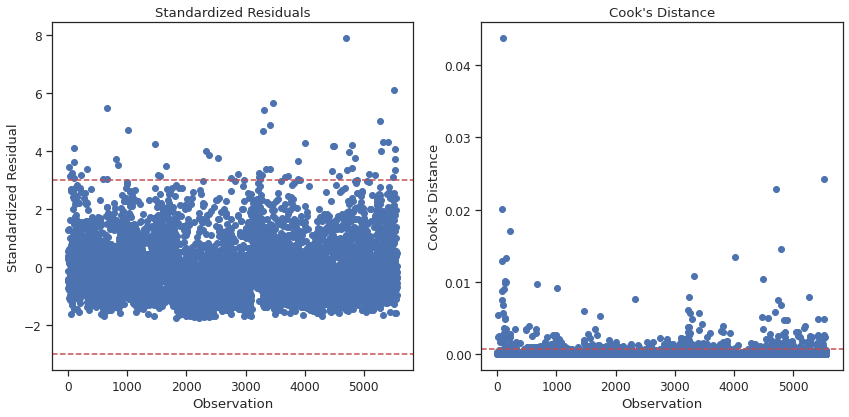

Quantity outliers (Standardized Residuals > 3): 64
Quantity influential Points (Cook's Distance > 4/n): 342

*** Period:  2021
Death mean:  76.25 variance:  227434.9 dispersion:  2982.56

===> model_6_2021
                               Feature       VIF
0                       Semi-urbanized  1.043208
1    Rural with high human development  1.003342
2  Urbanized with informal settlements  1.005715
3     Rural with low human development  1.034764


/home/helder/anaconda3/envs/base-r/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


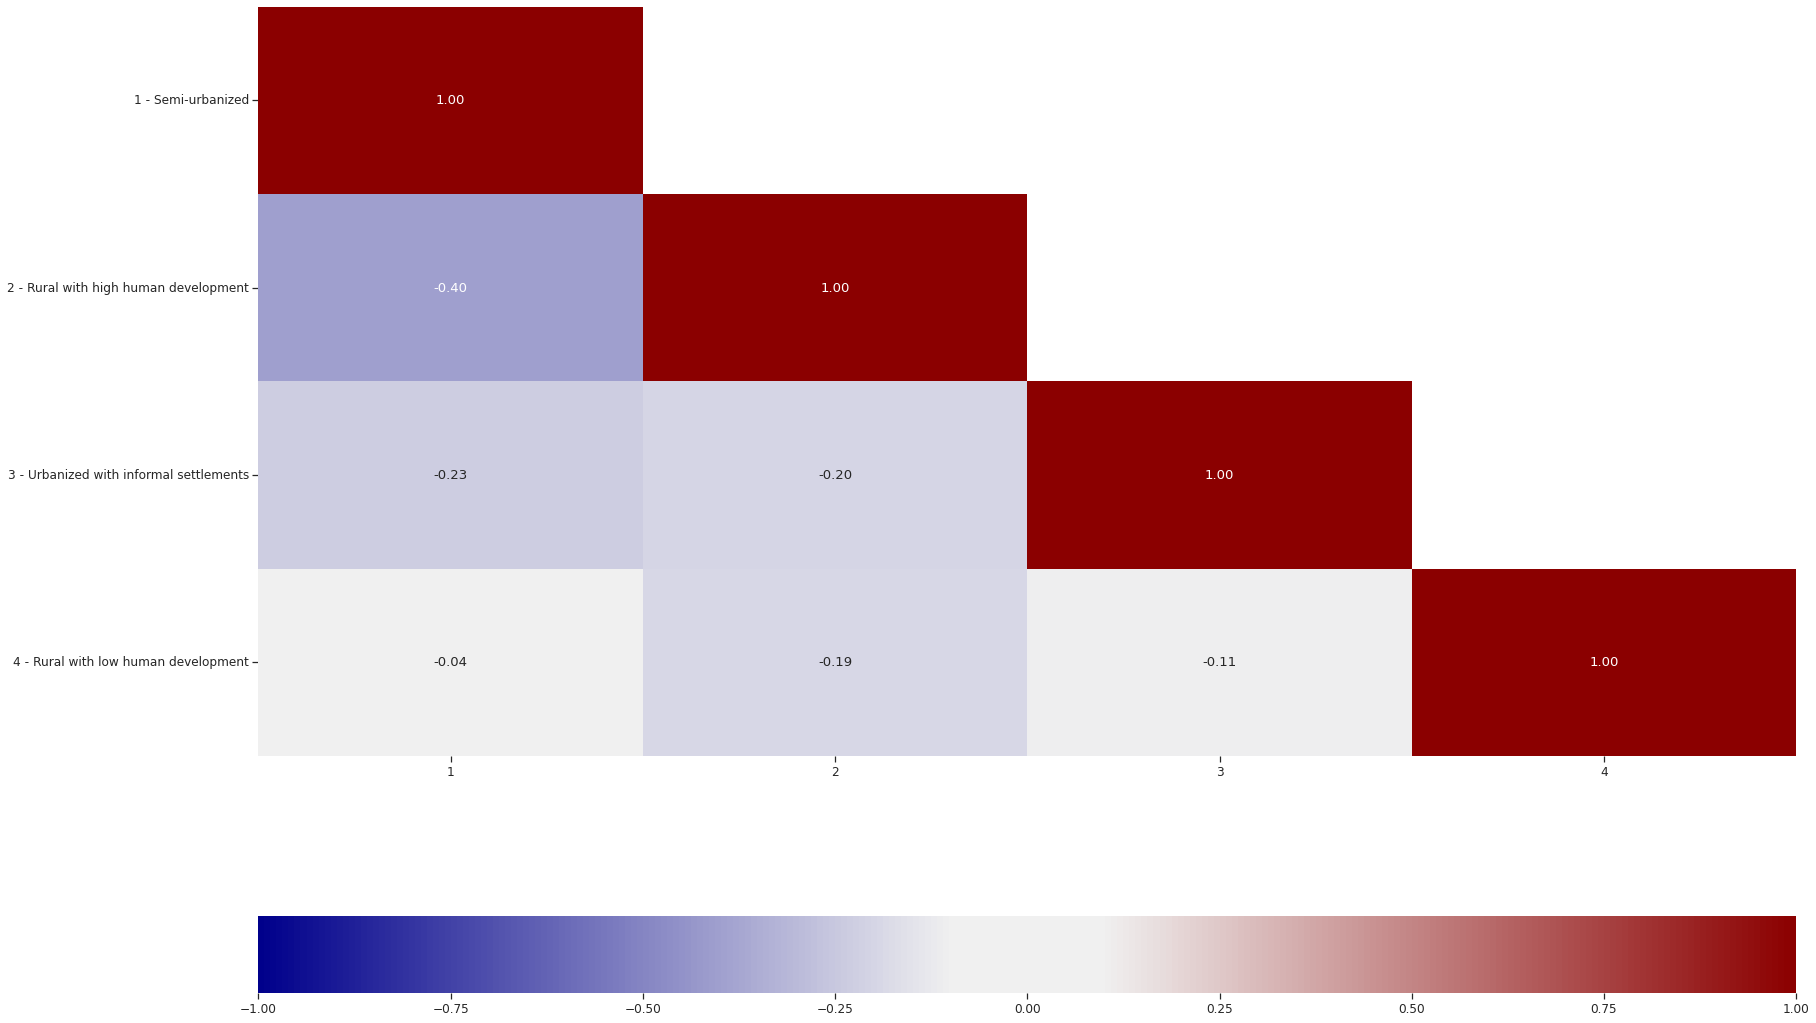

Selected alpha: 0.12
                 Generalized Linear Model Regression Results                  
Dep. Variable:            deaths_2021   No. Observations:                 5560
Model:                            GLM   Df Residuals:                     5555
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -20108.
Date:                Mon, 30 Dec 2024   Deviance:                       6061.2
Time:                        21:34:56   Pearson chi2:                 5.95e+03
No. Iterations:                     7   Pseudo R-squ. (CS):             0.5135
Covariance Type:            nonrobust                                         
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------

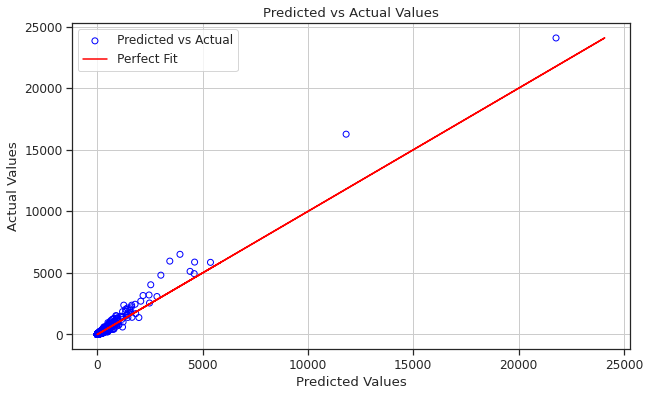

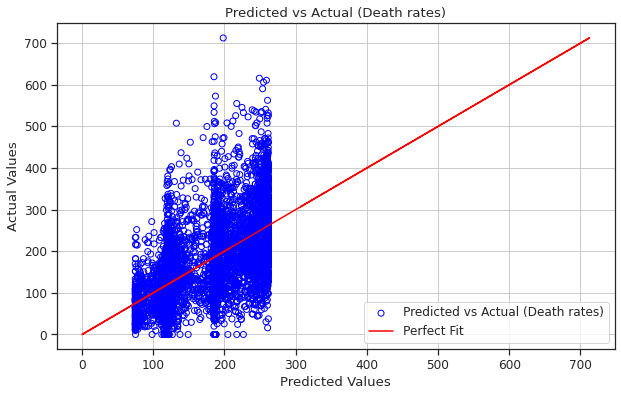

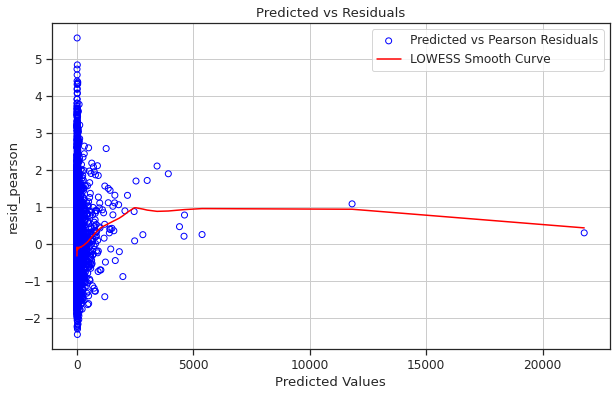

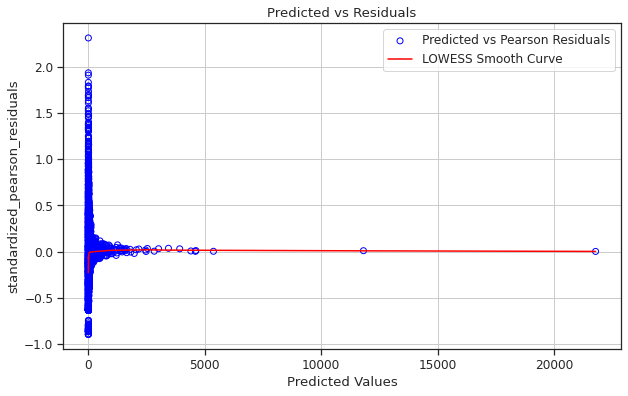


***Residuals:  resid_pearson
Shapiro-Wilk Test Statistic: 0.9614753723144531
p-value: 4.554033288837881e-36
Sample does not look Gaussian (reject H0)
Skewness: 0.8557333076248796
Kurtosis: 1.1619005902768746


/home/helder/anaconda3/envs/base-r/lib/python3.9/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


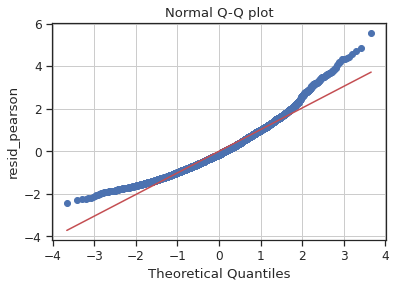


***Residuals:  standardized_pearson_residuals
Shapiro-Wilk Test Statistic: 0.9211214780807495
p-value: 0.0
Sample does not look Gaussian (reject H0)
Skewness: 1.2195867197044097
Kurtosis: 4.951284190181283


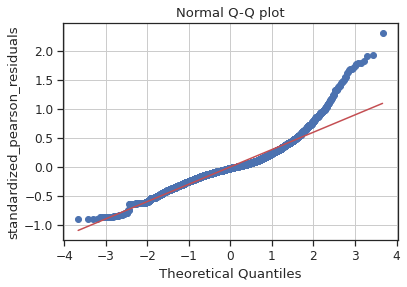

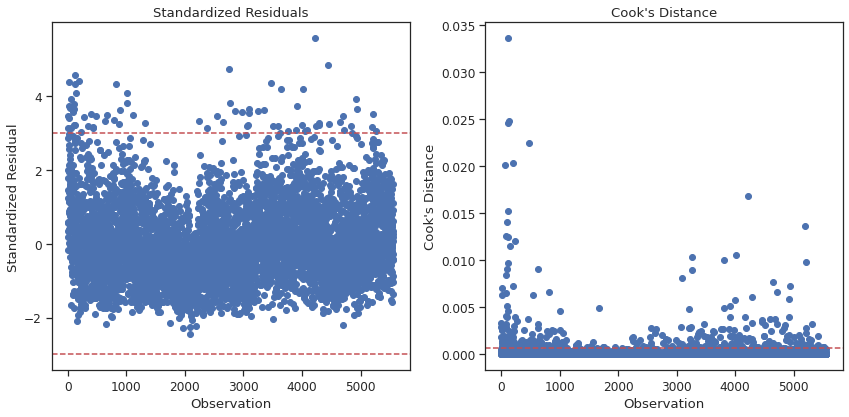

Quantity outliers (Standardized Residuals > 3): 74
Quantity influential Points (Cook's Distance > 4/n): 353

*** Period:  2022
Death mean:  11.75 variance:  4805.98 dispersion:  409.1

===> model_6_2022
                               Feature       VIF
0                       Semi-urbanized  1.043208
1    Rural with high human development  1.003342
2  Urbanized with informal settlements  1.005715
3     Rural with low human development  1.034764


/home/helder/anaconda3/envs/base-r/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


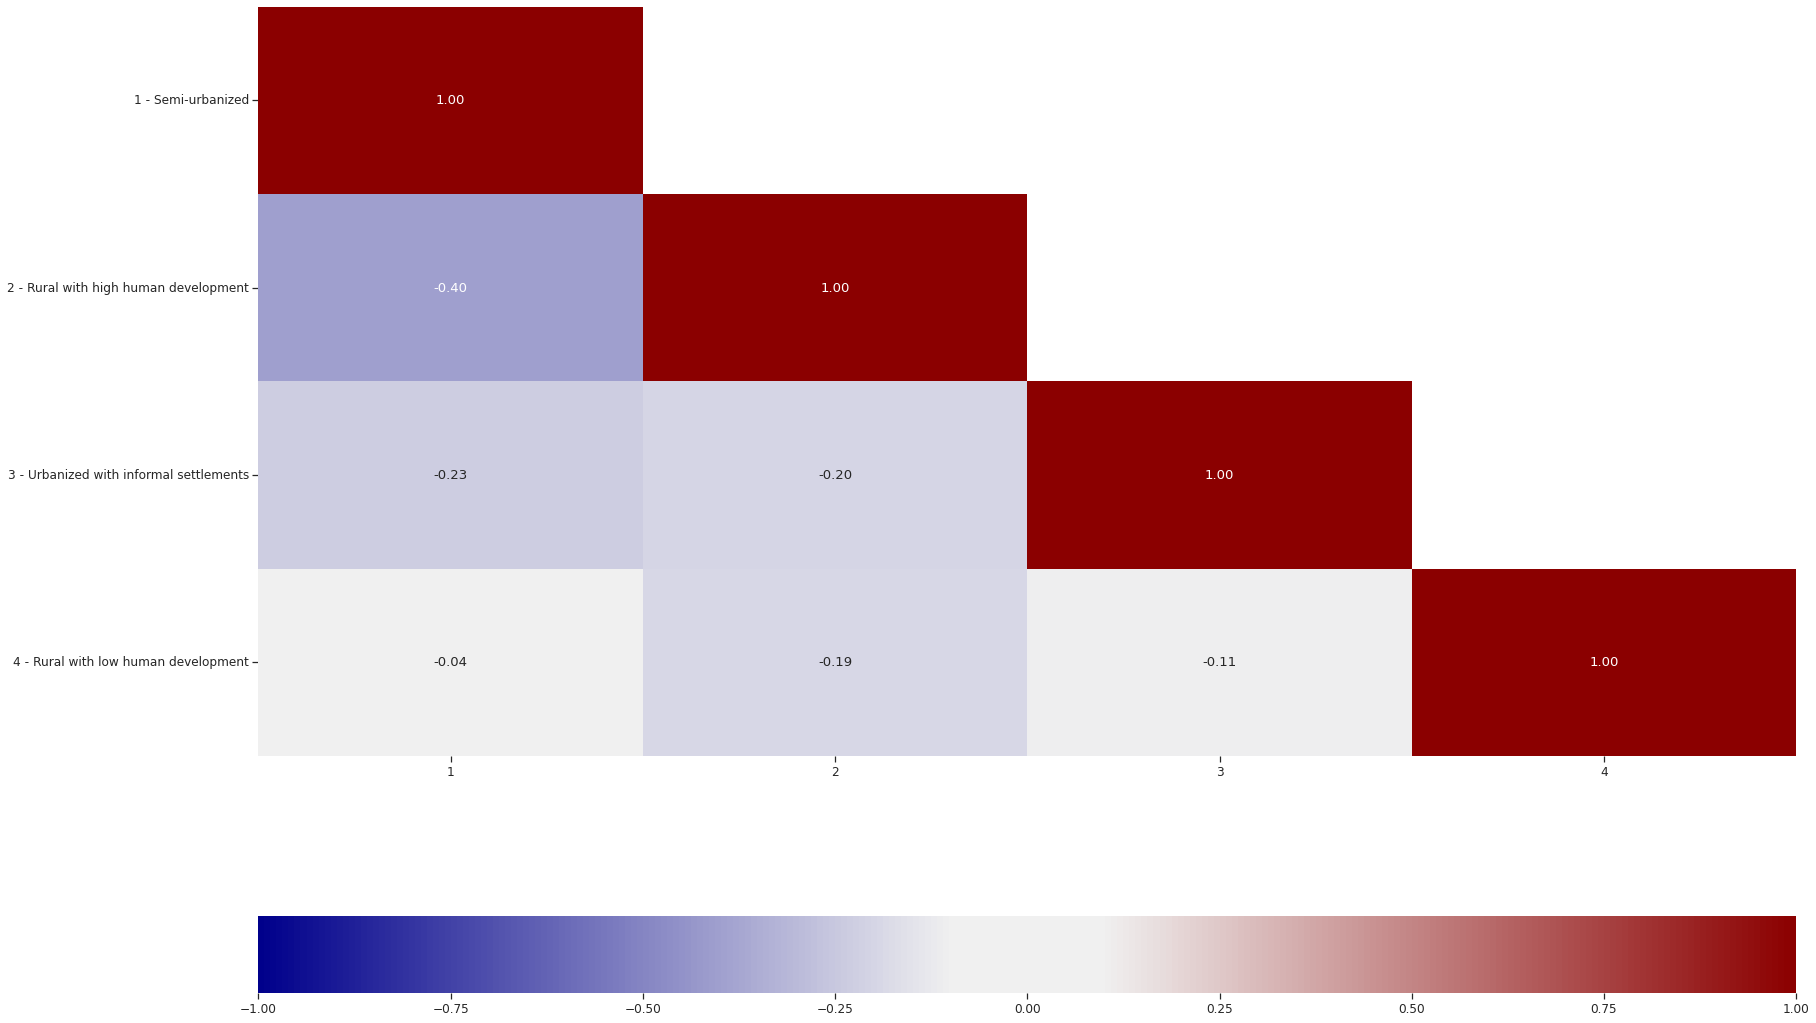

Selected alpha: 0.14
                 Generalized Linear Model Regression Results                  
Dep. Variable:            deaths_2022   No. Observations:                 5560
Model:                            GLM   Df Residuals:                     5555
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -12635.
Date:                Mon, 30 Dec 2024   Deviance:                       6081.1
Time:                        21:35:08   Pearson chi2:                 5.71e+03
No. Iterations:                     7   Pseudo R-squ. (CS):             0.2650
Covariance Type:            nonrobust                                         
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------

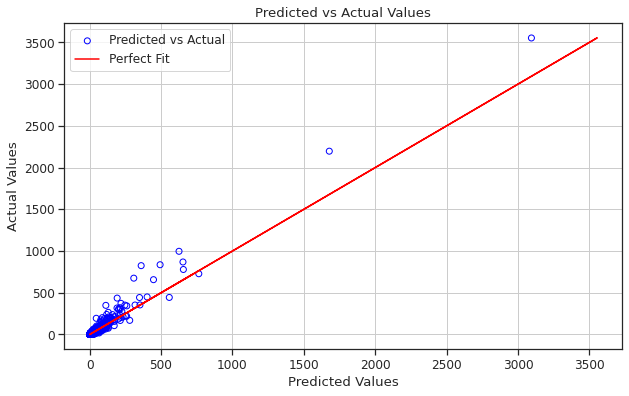

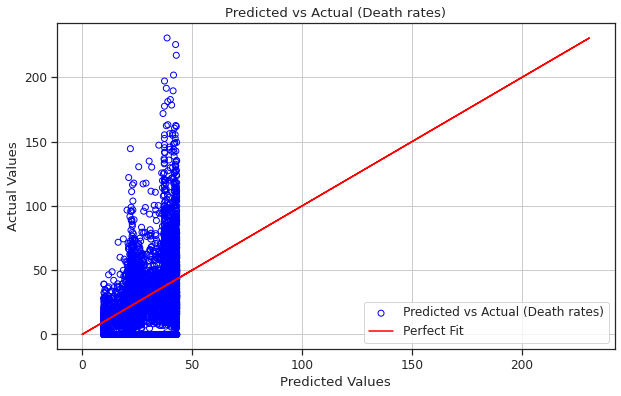

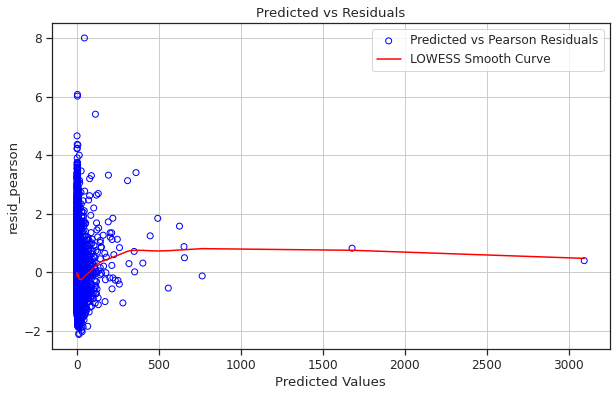

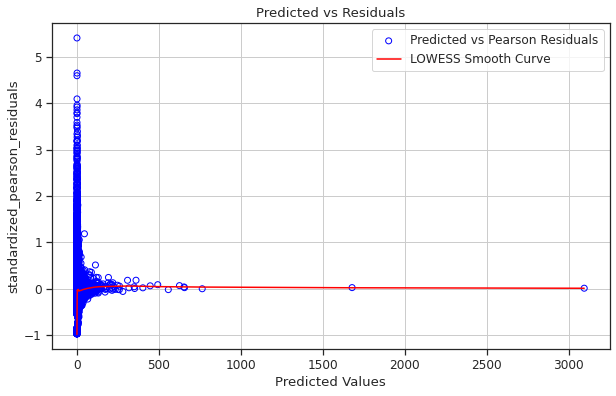


***Residuals:  resid_pearson
Shapiro-Wilk Test Statistic: 0.9451422691345215
p-value: 2.4829607489371434e-41
Sample does not look Gaussian (reject H0)
Skewness: 1.0185715571106997
Kurtosis: 1.8414751161239025


/home/helder/anaconda3/envs/base-r/lib/python3.9/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


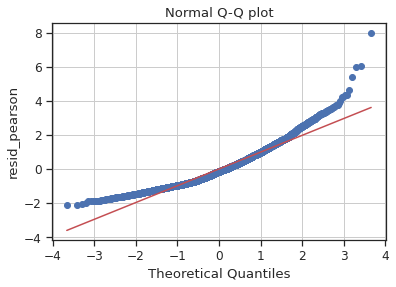


***Residuals:  standardized_pearson_residuals
Shapiro-Wilk Test Statistic: 0.8973064422607422
p-value: 0.0
Sample does not look Gaussian (reject H0)
Skewness: 1.5003107513650809
Kurtosis: 4.779588234548197


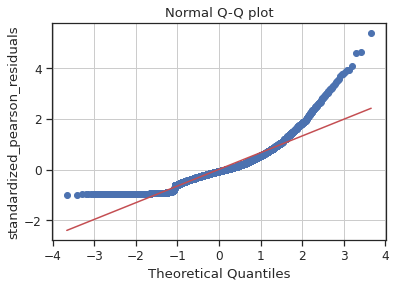

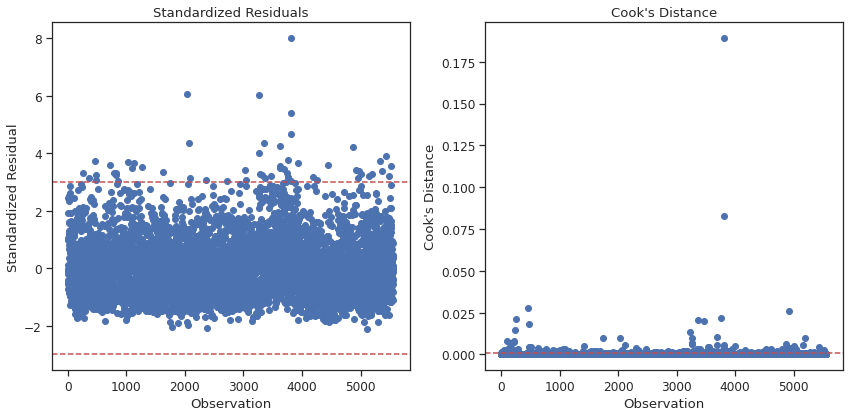

Quantity outliers (Standardized Residuals > 3): 57
Quantity influential Points (Cook's Distance > 4/n): 319

*** Period:  2020_2022
Death mean:  126.21 variance:  758887.04 dispersion:  6012.82

===> model_6_2020_2022
                               Feature       VIF
0                       Semi-urbanized  1.043208
1    Rural with high human development  1.003342
2  Urbanized with informal settlements  1.005715
3     Rural with low human development  1.034764


/home/helder/anaconda3/envs/base-r/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


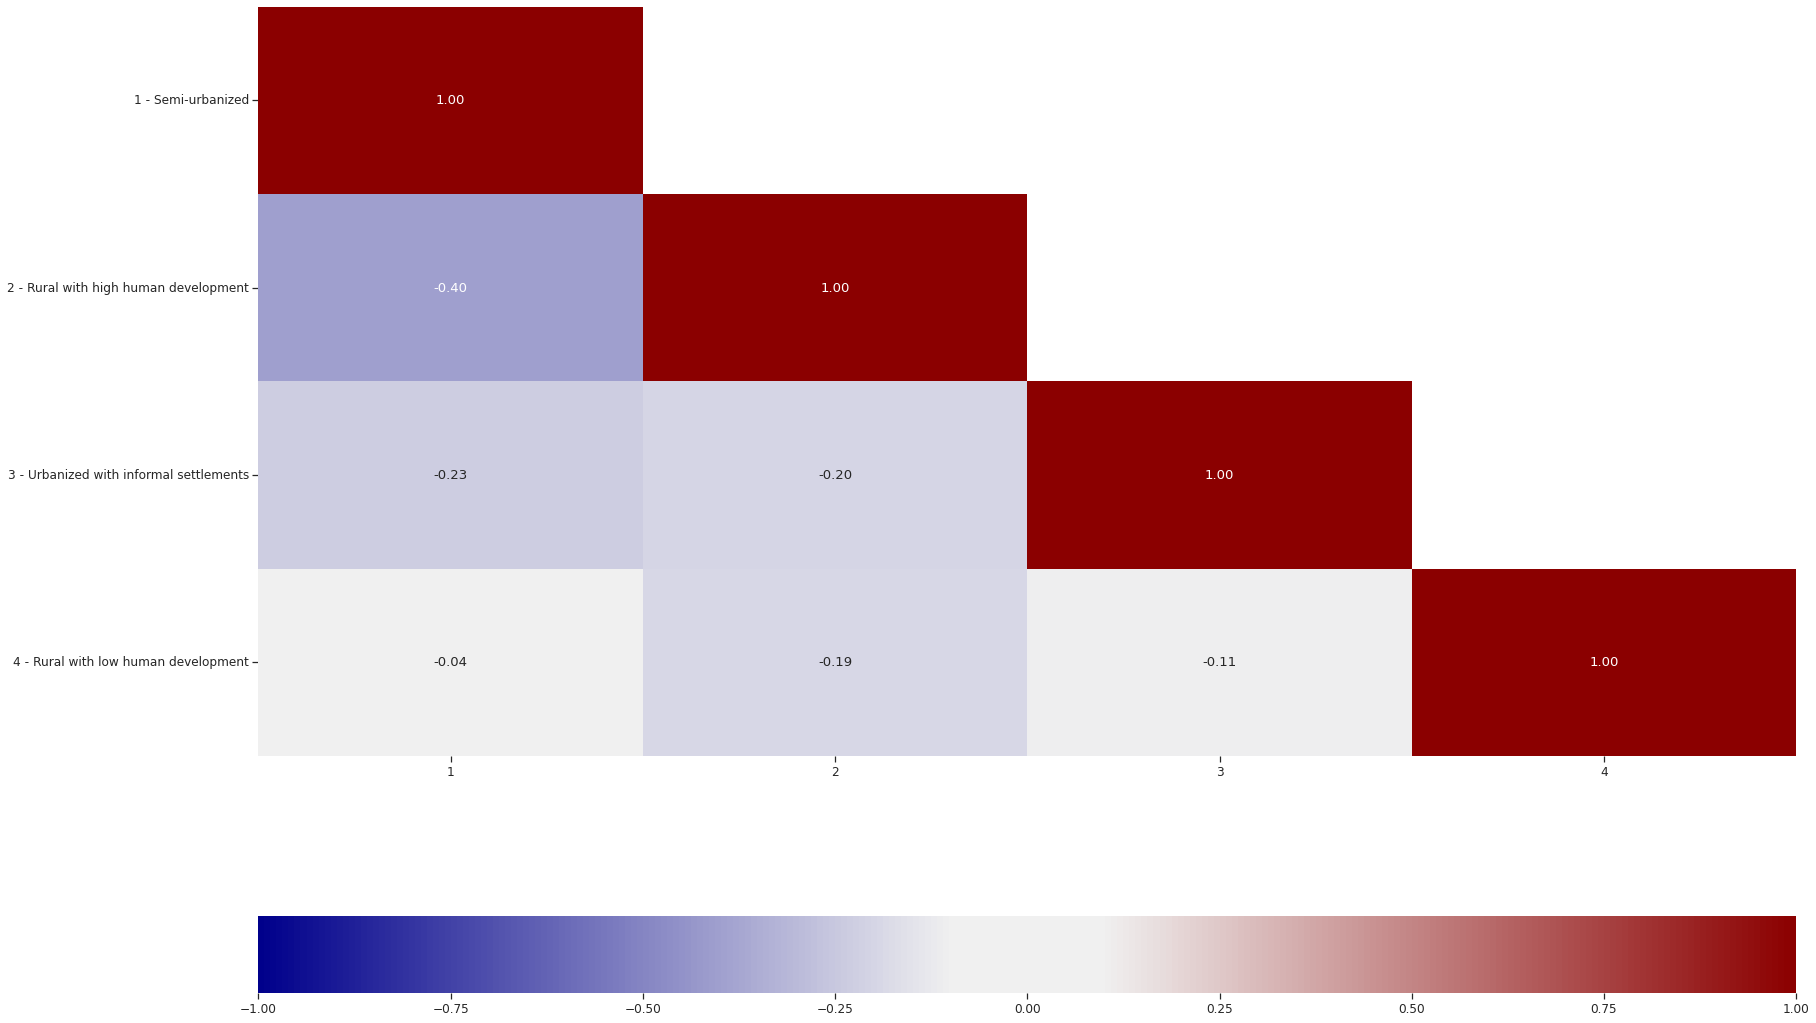

Selected alpha: 0.09999999999999999
                 Generalized Linear Model Regression Results                  
Dep. Variable:                 deaths   No. Observations:                 5560
Model:                            GLM   Df Residuals:                     5555
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -21888.
Date:                Mon, 30 Dec 2024   Deviance:                       5765.5
Time:                        21:35:23   Pearson chi2:                 5.63e+03
No. Iterations:                     7   Pseudo R-squ. (CS):             0.4262
Covariance Type:            nonrobust                                         
                                          coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------

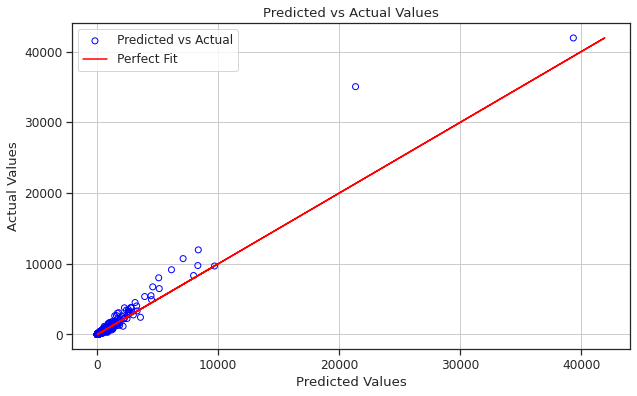

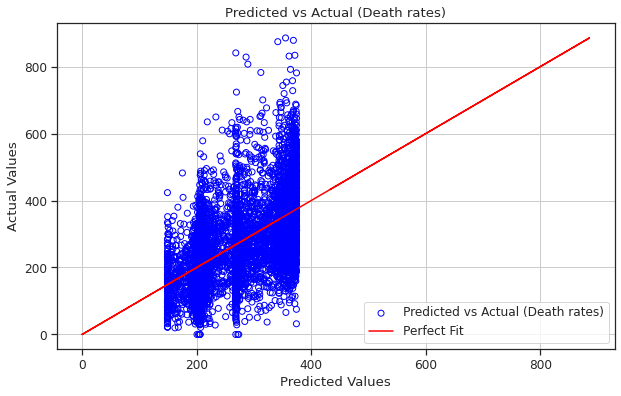

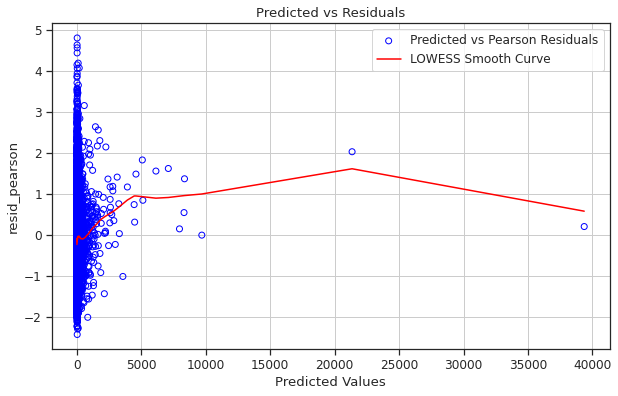

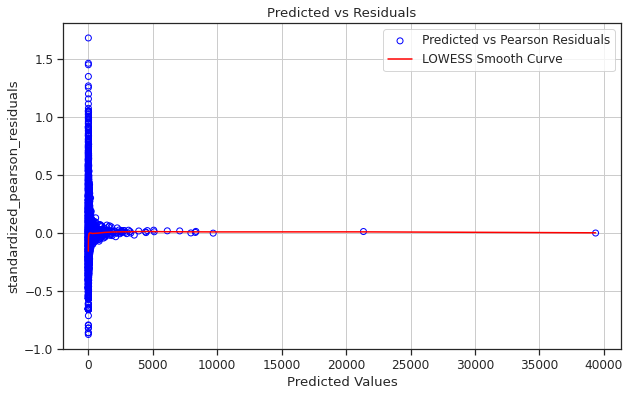


***Residuals:  resid_pearson
Shapiro-Wilk Test Statistic: 0.9750214219093323
p-value: 3.989901293696619e-30
Sample does not look Gaussian (reject H0)
Skewness: 0.6767126279071296
Kurtosis: 0.6873400249204669


/home/helder/anaconda3/envs/base-r/lib/python3.9/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


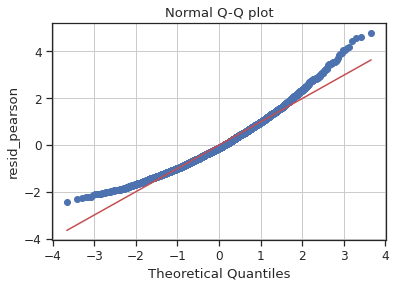


***Residuals:  standardized_pearson_residuals
Shapiro-Wilk Test Statistic: 0.9422475099563599
p-value: 3.9628720571105827e-42
Sample does not look Gaussian (reject H0)
Skewness: 0.8884336108862017
Kurtosis: 3.674436779595986


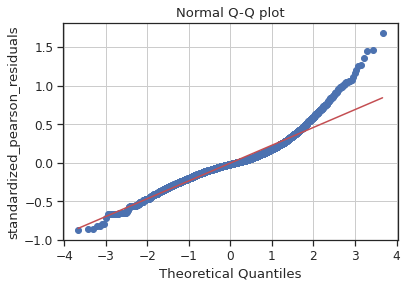

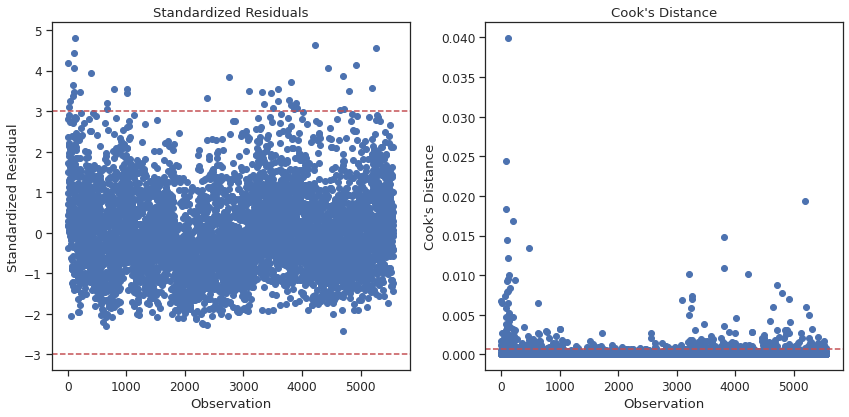

Quantity outliers (Standardized Residuals > 3): 40
Quantity influential Points (Cook's Distance > 4/n): 328


In [48]:
list_columns_y = ['deaths_accumulated_first_semester_2020', 'deaths_accumulated_2020', 'deaths_2021', 'deaths_2022', 'deaths']
list_periods = ['2020_1','2020', '2021', '2022', '2020_2022']
list_delta_first_death_columns = ['delta_first_death_2020-06-30', 'delta_first_death_2020-12-31', 'delta_first_death_2021-12-31', 'delta_first_death_2022-12-31', 'delta_first_death_general_period']
vaccination_columns = [0,1,2,3,3]

for i in range(5):
    column_y = list_columns_y[i]
    period = list_periods[i]
    column_delta_first_death = list_delta_first_death_columns[i]
    list_offset_extra = np.log(df_y[column_delta_first_death]+1)
    list_offset_latitude = np.log(df_latitude_longitude['latitude'])
    list_offset_longitude = np.log(df_latitude_longitude['longitude'])
    print('\n*** Period: ', period)
        
    y = df_y[column_y]
    print('Death mean: ', round(y.mean(),2), 'variance: ', round(y.var(),2), 'dispersion: ', round(y.var()/y.mean(),2))
    
    # # # Model 0
    # x = df_regions.copy()
    # x = pd.get_dummies(x, columns=['region'], drop_first=True, dtype=int)
    # x = x.sort_index()
    # model0 = run_model(x, y, 'model_0', period)
    #
    # # # Model 1
    # x = df_regions.copy()
    # x = pd.get_dummies(x, columns=['region'], drop_first=True, dtype=int)
    # x = x.sort_index()
    # model1 = run_model(x, y, 'model_1', period, list_offset_extra=list_offset_extra)

    # # # Model 2
    # x = df_cluster_labels.copy()
    # x = pd.get_dummies(x, columns=['cluster_label'], drop_first=True, dtype=int)
    # x = x.sort_index()
    # run_model(x, y, 'model_2', period)

    # # Model 3
    # x = df_cluster_labels.copy()
    # x = pd.get_dummies(x, columns=['cluster_label'], drop_first=True, dtype=int)
    # x = x.sort_index()
    # model3 = run_model(x, y, 'model_3', period, list_offset_extra=list_offset_extra)

    # Model 4
    # x = df_latitude_longitude.copy()
    # x = x.sort_index()
    # run_model(x, y, 'model_4', period)

    # Model 5
    # x = df_cluster_labels.copy()
    # x = pd.get_dummies(x, columns=['cluster_label'], drop_first=True, dtype=int)
    # x = x.sort_index()
    # df_latitude_longitude = df_latitude_longitude.sort_index()
    # x = pd.concat([df_latitude_longitude, x], axis=1)
    # run_model(x, y, 'model_5', period)

    # Model 6
    x = df_cluster_probabilities.drop(columns=['Urbanized']).copy()
    run_model(x, y, 'model_6', period)

    # Model 7
    # x = df_cluster_probabilities.drop(columns=['Urbanized']).copy()
    # x = pd.concat([df_latitude_longitude, x], axis=1)
    # scaler = StandardScaler()
    # x_standardized = scaler.fit_transform(x)
    # x = pd.DataFrame(x_standardized, index=x.index, columns=x.columns)
    # run_model(x, y, 'model_7', period)

    # Model 8
    # x = df_cluster_probabilities.drop(columns=['Urbanized']).copy()
    # x = pd.concat([df_latitude_longitude, x], axis=1)
    # scaler = StandardScaler()
    # x_standardized = scaler.fit_transform(x)
    # x = pd.DataFrame(x_standardized, index=x.index, columns=x.columns)
    # run_model(x, y, 'model_8', period, list_offset_extra=list_offset_extra)

    # # Model 9
    # x = df_cluster_probabilities.drop(columns=['Urbanized']).copy()
    # run_model(x, y, 'model_9', period, list_offset_extra=list_offset_extra)

    # Model 10
    # x = df_variables.copy()
    # scaler = StandardScaler()
    # percentage_votes_for_bolsonaro_standardized = scaler.fit_transform(df_political)
    # x['percentage_votes_for_bolsonaro'] = percentage_votes_for_bolsonaro_standardized[:,0]
    # vaccination_column = vaccination_columns[i]
    # vaccination_standardized = scaler.fit_transform(df_vaccination_fully_vaccinated_people)
    # x['% people fully vaccinated'] = vaccination_standardized[:, vaccination_column]
    # run_model(x, y, 'model_10', period, list_offset_extra=list_offset_extra)

In [49]:
x.describe().round(2)

,Semi-urbanized,Rural with high human development,Urbanized with informal settlements,Rural with low human development
count,5560.00,5560.00,5560.00,5560.00
mean,0.36,0.17,0.08,0.07
std,0.42,0.30,0.20,0.20
min,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,0.00
50%,0.06,0.01,0.01,0.00
75%,0.88,0.16,0.04,0.02
max,0.98,1.00,1.00,1.00
